In [3]:
# --- One-time setup 
import sys, subprocess

def pip_install(pkg):
    try:
        __import__(pkg.split("[")[0].replace("-", "_"))
    except ImportError:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

# (pip install)
pip_install("sentence-transformers")
pip_install("fuzzywuzzy[speedup]")
pip_install("groq")        
pip_install("openai")      


Installing sentence-transformers ...
Installing fuzzywuzzy[speedup] ...
Installing groq ...
Installing openai ...


In [41]:

# ===============================
# Core
# ===============================
!pip install umap-learn
import os, re, warnings
import numpy as np
!pip install pandas
import pandas as pd
import joblib
from tqdm import tqdm
warnings.filterwarnings("ignore")

# ===============================
# NLP / Vectorization
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# embedding baseline (semantic retrieval)
from sentence_transformers import SentenceTransformer

# fuzzy matching utility 
from fuzzywuzzy import fuzz

# ===============================
# Modeling (classification scope)
# ===============================
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# ===============================
# Metrics
# ===============================
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality-reduction for visuals 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap  # This will now work after installing umap-learn

# ===============================
# LLM Clients (for narrative layer)
# ===============================
from groq import Groq        
from openai import OpenAI

In [7]:
!python -m spacy download en_core_web_sm
!pip install python-Levenshtein


C:\Users\John\anaconda3\python.exe: No module named spacy


In [43]:



import os
df = pd.read_csv(os.path.join(os.path.expanduser("~"), "Downloads/cleaned_work_orders.csv"))

df = df.dropna(how='all')

# Drop noise in Data
df = df[~df['Text'].str.contains("completed", case=False, na=False)]
df = df[~df['Text'].str.contains("complete", case=False, na=False)]
df = df[~df['Text'].str.contains("mike", case=False, na=False)]
df = df[~df['Text'].str.contains("mike's", case=False, na=False)]
df = df[~df['Text'].str.contains("odd", case=False, na=False)]

df = df.dropna(subset=['Description', 'Text']).drop_duplicates()

# Keep only rows where WO No. is numeric
df = df[df['WO No.'].astype(str).str.match(r'^\d+$')]

# Strip spaces and standardize text fields
df['WO No.'] = df['WO No.'].astype(str).str.strip()
df['Description'] = df['Description'].astype(str).str.strip()
df['Text'] = df['Text'].astype(str).str.strip()

# Clean Description
df['Description_cleaned'] = (
    df['Description']
    .fillna("")
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
    .str.replace(r'\d+', '', regex=True)      # Remove digits
    .str.strip()
)

# Clean Technician Text Notes
df['Text_cleaned'] = (
    df['Text']
    .fillna("")
    .str.lower()
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.replace(r'\d+', '', regex=True)
    .str.strip()
)

# Keep rows where both sides exist and are not trivial
df = df[['Description_cleaned', 'Text_cleaned']].dropna()
df = df[df['Description_cleaned'].str.strip() != ""]
df = df[df['Text_cleaned'].str.strip() != ""]

# Filter out rows with completely blank descriptions and notes
df = df[~((df['Description_cleaned'].str.strip() == "") & (df['Text_cleaned'].str.strip() == ""))]

# Ensure valid technician notes
df = df[df['Text_cleaned'].notna() & (df['Text_cleaned'].str.strip() != "") & (df['Text_cleaned'].str.lower().str.strip() != "nan")]

# Show data sample for verification
display(df[['Description_cleaned', 'Text_cleaned']].head())

,Description_cleaned,Text_cleaned
9,cushion,checking on a new controller ordered controller
11,take out section of conveyor on vertical oven ...,took out about ft of chain
12,stop time,press was in a wierd position causing the disc...
13,remove gas meter from solder pour machine,removed gas meter and installed replacement pipe
23,check bearings making noise,problem stopped


In [45]:
# Map free-text notes to a small, useful label set.

# --- 1) Primary rule-based mapping ---
ACTION_PATTERNS = [
    ("Replace Part",   r"\b(replace|replaced|swap|swapped|install(ed)?)\b.*\b(bearing|motor|belt|gear|fuse|sensor|valve|hose|coupling|chain|switch|roller|pulley|seal)\b"),
    ("Tighten/Adjust", r"\b(tighten|tightened|adjust|adjusted|align|aligned|re-seat|reseat|calibrate|calibrated|reposition|realign(ed)?)\b"),
    ("Clean/Clear",    r"\b(clean|cleaned|clear|cleared|remove|removed)\b.*\b(debris|dust|jam|blockage|clog)\b|\b(cleaned|cleared)\b"),
    ("Refill/Top Off", r"\b(add|added|refill|refilled|top\s?off)\b.*\b(oil|fluid|grease|lub(e|ricant)|coolant)\b"),
    ("Electrical Fix", r"\b(replace|replaced|reset|rewire|wire(d)?|reconnect|connector|contactor|breaker|fuse|vfd|plc|relay)\b"),
    ("Hydraulic/Pneumatic Fix", r"\b(hose|cylinder|solenoid|regulator|air line|hydraulic|pneumatic)\b.*\b(repair|replace|fixed|leak|leaking)\b"),
    ("Reset/Power Cycle", r"\b(reset|power.?cycle|cycled|restart|reboot|restarted)\b"),
    ("Inspection/Test Only", r"\b(inspect|inspected|tested|verify|verified|checked)\b(?!.*replace|.*repair|.*fix)"),
    ("Other", r".*")
]

import re

def to_response_label(text: str) -> str:
    t = " " + str(text).lower() + " "
    for label, pat in ACTION_PATTERNS:
        if re.search(pat, t):
            return label
    return "Other"

df['Response_Label'] = df['Text_cleaned'].apply(to_response_label)


# --- 2) Secondary re-mapping for rows still tagged "Other" ---
# Uses precise bigrams first, then high-signal unigrams, mapped into EXISTING labels only.

BIGRAM_MAP = [
    # Installation / replacement
    (["installed new", "fabricated new", "changed torch", "removed broken"], "Replace Part"),

    # Pneumatic / hydraulic
    (["air line", "air pressure", "air leak", "solenoid valve", "foot pedal"], "Hydraulic/Pneumatic Fix"),

    # Electrical
    (["limit switch", "power supply", "light curtain", "repaired wiring"], "Electrical Fix"),

    # Inspection / test outcomes
    (["started working", "went away", "working ok", "worked fine", "ran fine"], "Inspection/Test Only"),

    # Mechanical tighten/adjust
    (["came loose", "took apart"], "Tighten/Adjust"),
]

UNIGRAM_MAP = [
    # Installation / replacement
    (["installed", "install", "changed", "removed", "new"], "Replace Part"),

    # Pneumatic / hydraulic
    (["air", "line", "hose", "pump", "cylinder", "solenoid", "regulator"], "Hydraulic/Pneumatic Fix"),

    # Electrical
    (["switch", "wiring", "controller", "power", "fuse"], "Electrical Fix"),

    # Inspection / test / ambiguous OK
    (["found", "checked", "ok", "not working", "problem"], "Inspection/Test Only"),

    # Mechanical adjust
    (["loose", "aligned", "adjust", "tighten", "tightened"], "Tighten/Adjust"),
]

def remap_other_label(note: str) -> str:
    t = str(note).lower()

    # 1) Bigram priority (exact substring search for speed/clarity)
    for phrases, mapped in BIGRAM_MAP:
        if any(p in t for p in phrases):
            return mapped

    # 2) Unigram fallbacks
    for terms, mapped in UNIGRAM_MAP:
        if any(w in t for w in terms):
            return mapped

    return "Other"

mask_other = (df["Response_Label"] == "Other")
df.loc[mask_other, "Response_Label"] = df.loc[mask_other, "Text_cleaned"].apply(remap_other_label)


# --- 3) Collapse tiny labels again (keeps classes trainable) ---
min_count = 15
vc = df['Response_Label'].value_counts()
valid = vc[vc >= min_count].index
df.loc[~df['Response_Label'].isin(valid), 'Response_Label'] = "Other"

# new distribution to confirm "Other" 
print("Label distribution AFTER re-map:\n", df['Response_Label'].value_counts())



Label distribution AFTER re-map:
 Response_Label
Electrical Fix             14487
Other                       9822
Replace Part                8775
Tighten/Adjust              5862
Hydraulic/Pneumatic Fix     3718
Inspection/Test Only        3388
Clean/Clear                 3170
Reset/Power Cycle            226
Refill/Top Off               211
Name: count, dtype: int64


# **3. Dimensionality Reduction (PCA/TSNE/UMAP for visuals)**

# PCA

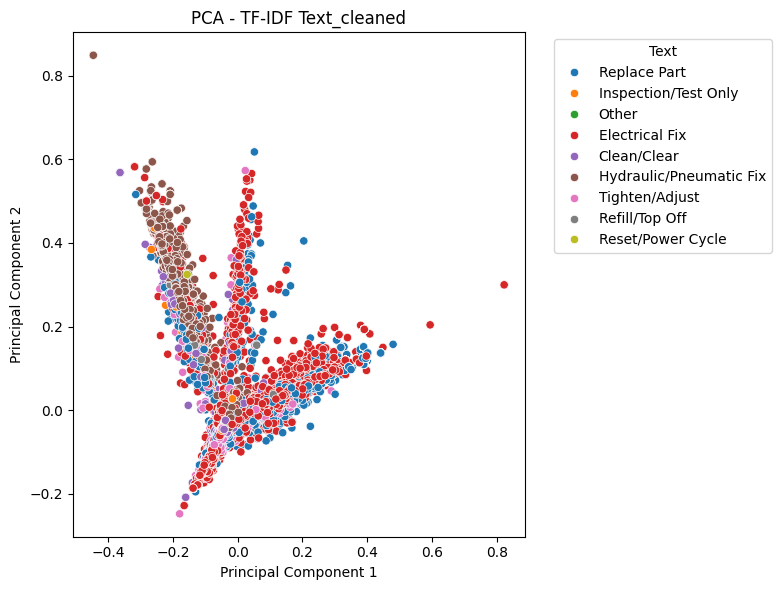

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer # Ensure TfidfVectorizer is imported if not globally available

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(df['Text_cleaned'].fillna(''))
y = df['Response_Label']

# Use sklearn's PCA explicitly
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='tab10')
plt.title("PCA - TF-IDF Text_cleaned")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Text', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# TSNE

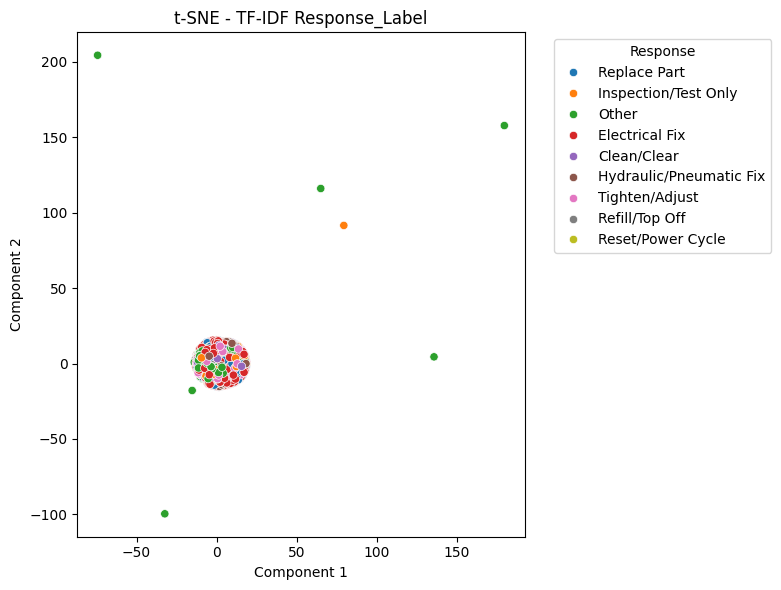

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10')
plt.title("t-SNE - TF-IDF Response_Label")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# UMAP

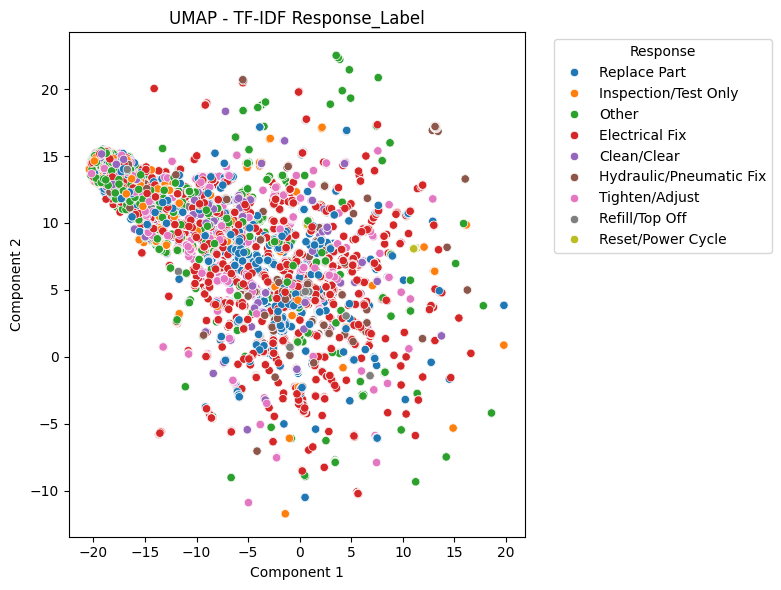

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_tfidf)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='tab10')
plt.title("UMAP - TF-IDF Response_Label")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Saving visual artifacts to: /content/drive/MyDrive/MainXance/vis_artifacts
Running PCA(2)…


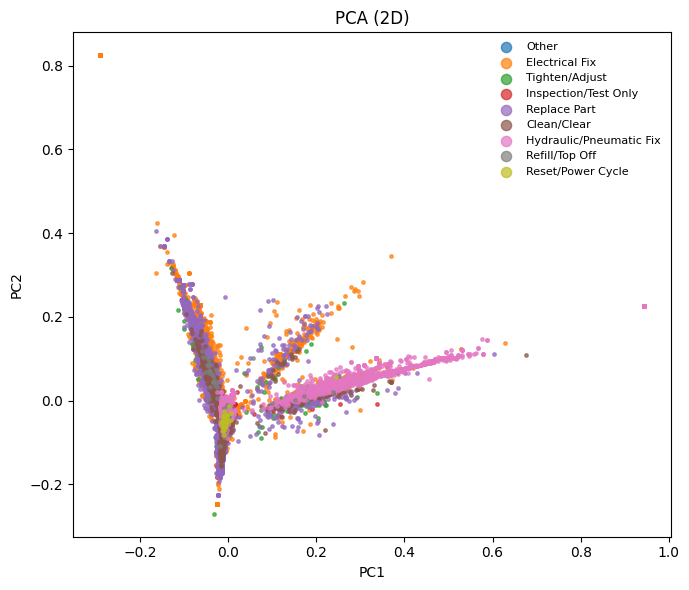

Running t-SNE(2)… (subsample if needed)


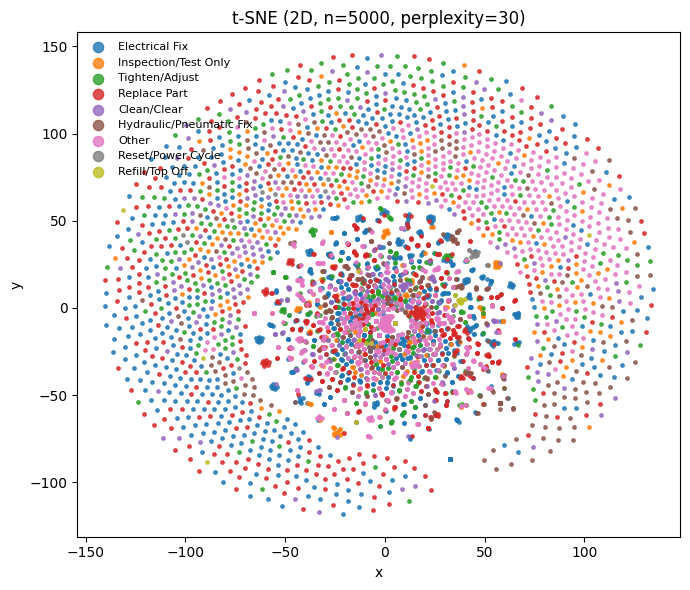

Running UMAP(2)… (subsample if needed)


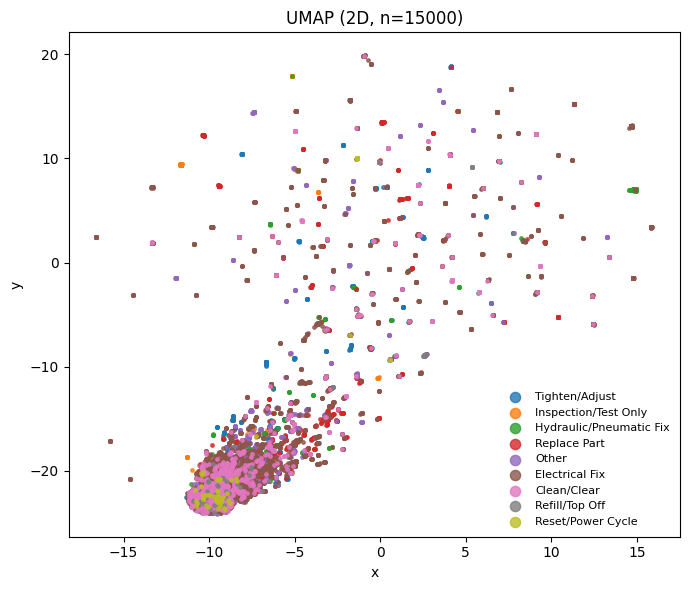

Done. Files written to: /content/drive/MyDrive/MainXance/vis_artifacts


In [ ]:
# ==== Save PCA / t-SNE / UMAP artifacts & plots ====
import numpy as np, pandas as pd, joblib, time
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# y labels for coloring
try:
    y_labels = y_train_text.astype(str).reset_index(drop=True)
except Exception:
    y_labels = None

# Helper: convert to dense float32 safely
def to_dense_float32(X):
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X)
    if X.dtype != np.float32:
        X = X.astype(np.float32, copy=False)
    return X

# Use the TRAIN matrix you clustered/classified on
assert 'X_train' in globals(), "X_train_vec not found. Provide your train feature matrix."
Xmat_full = X_train
n = Xmat_full.shape[0]

# Subsample for heavy methods to keep plots readable/fast
MAX_TSNE = 5000
MAX_UMAP = 15000
rng = np.random.RandomState(42)

def subsample(X, y, k):
    if X.shape[0] <= k:
        return X, y, np.arange(X.shape[0])
    idx = rng.choice(X.shape[0], k, replace=False)
    if y is not None:
        return X[idx], y.iloc[idx].reset_index(drop=True), idx
    return X[idx], None, idx

# ---------- PCA (fast, saves model + coords + plot) ----------
print("Running PCA(2)…")
Xp = to_dense_float32(Xmat_full)
pca = PCA(n_components=2, random_state=42)
P_pca = pca.fit_transform(Xp)

# Plot PCA
plt.figure(figsize=(7,6))
if y_labels is not None:
    # basic coloring by label
    for lab in pd.Series(y_labels).unique():
        m = (y_labels == lab).values
        plt.scatter(P_pca[m,0], P_pca[m,1], s=6, alpha=0.7, label=str(lab))
    plt.legend(markerscale=3, fontsize=8, frameon=False)
else:
    plt.scatter(P_pca[:,0], P_pca[:,1], s=6, alpha=0.7)
plt.title("PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# ---------- t-SNE (coords + plot; no reusable model) ----------
print("Running t-SNE(2)… (subsample if needed)")
Xts, yts, idx_ts = subsample(Xp, y_labels, MAX_TSNE)

# Pick a sane perplexity relative to sample size
perp = max(5, min(30, (Xts.shape[0] - 1) // 3))
tsne = TSNE(n_components=2, perplexity=perp, learning_rate="auto",
            init="pca", n_iter=1000, random_state=42, verbose=0)
P_tsne = tsne.fit_transform(Xts)

# ---------- UMAP (saves model + coords + plot, if available) ----------
print("Running UMAP(2)… (subsample if needed)")
HAS_UMAP = False
try:
    import umap.umap_ as umap
    HAS_UMAP = True
except Exception:
    pass

if HAS_UMAP:
    Xum, yum, idx_um = subsample(Xp, y_labels, MAX_UMAP)
    um = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="euclidean",
        random_state=42,
        verbose=False,
    )
    P_umap = um.fit_transform(Xum)

    # Save UMAP model & coords
    joblib.dump(um, SAVE_DIR / "umap_2d.joblib")
    pd.DataFrame({
        "umap_x": P_umap[:,0],
        "umap_y": P_umap[:,1],
        "label": yum if yum is not None else None,
        "orig_index": idx_um
    }).to_csv(SAVE_DIR / "umap_2d_coords.csv", index=False)

    # Plot UMAP
    plt.figure(figsize=(7,6))
    if yum is not None:
        for lab in pd.Series(yum).unique():
            m = (yum == lab).values
            plt.scatter(P_umap[m,0], P_umap[m,1], s=6, alpha=0.8, label=str(lab))
        plt.legend(markerscale=3, fontsize=8, frameon=False)
    else:
        plt.scatter(P_umap[:,0], P_umap[:,1], s=6, alpha=0.8)
    plt.title(f"UMAP (2D, n={Xum.shape[0]})")
    plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout(); plt.show()
else:
    print("UMAP not installed; skipped. Install with: pip install umap-learn")

print("Done. Files written to:", SAVE_DIR.resolve())

# Sentence Transformer


In [19]:
# Load the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define features and labels
X = model.encode(df['Description_cleaned'].tolist(), show_progress_bar=True)
y = df['Response_Label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1552 [00:00<?, ?it/s]

In [20]:
# Set up features and labels
X_embed = model.encode(df['Description_cleaned'].tolist(), show_progress_bar=True)
X = X_embed
y = df['Response_Label']

Batches:   0%|          | 0/1552 [00:00<?, ?it/s]